In [1]:
pip install astroscrappy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clip
from astropy.visualization import ImageNormalize, LinearStretch, ZScaleInterval
from astroscrappy import detect_cosmics
from astropy.stats import sigma_clipped_stats
from photutils.aperture import CircularAperture
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAnnulus
from photutils.aperture import ApertureStats
from photutils.profiles import RadialProfile
from photutils.centroids import centroid_1dg

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from photutils.detection import DAOStarFinder

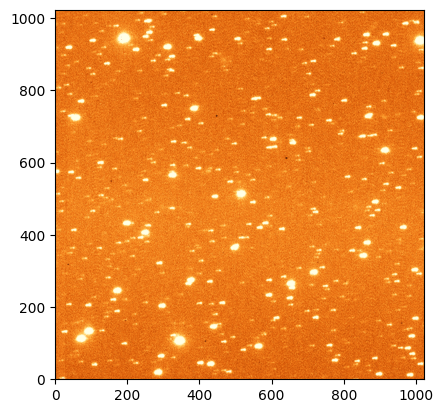

In [4]:
ccd37_proc = fits.open(f'~/work/ccd-reductions-mbosch2/Processed_2/KIC 9832227_r_20250606_040813.fits')
ccd37_proc_data = ccd37_proc[0].data.astype('f4')

# Plot the flat image
norm = ImageNormalize(ccd37_proc_data, interval=ZScaleInterval(), stretch=LinearStretch())
_ = plt.imshow(ccd37_proc_data, origin='lower', norm=norm, cmap='YlOrBr_r')

In [5]:
# Select a blank region of the image
data_blank = ccd37_proc_data[800:900, 100:200]  #100:200,

# Calculate the mean, median and standard deviation of the blank region
mean, median, std = sigma_clipped_stats(data_blank, sigma=3.0)
print(f'Mean: {mean:.2f}, Median: {median:.2f}, Std: {std:.2f}')

Mean: 416.81, Median: 416.26, Std: 22.51


In [6]:
# Run DAOStarFinder
daofind = DAOStarFinder(fwhm=5.0, threshold=5*std)
sources = daofind(ccd37_proc_data - median)

print(sources)

 id     xcentroid          ycentroid      ...    mag         daofind_mag     
--- ------------------ ------------------ ... ---------- --------------------
  1 15.092699461390827 1.9520099080798585 ...  -8.215109 -0.19065519498713993
  2 22.689422721519172 1.7411299124535948 ...   -9.40569  -1.5299106247575358
  3   977.953785721207 10.953491516230914 ... -10.520594   -2.191192004091007
  4  985.2616890843469 11.614453791983236 ... -11.175764  -2.7994951294156256
  5  891.6796178945691 13.435346920726914 ...  -10.56733   -2.306662245349483
  6  899.3123925651456  14.06310619116366 ...  -11.25834   -2.879586829802091
  7  280.2152006025276  17.92927594015946 ... -12.227688  -3.9296502325774725
  8 287.51249914615124 18.767652074218123 ... -12.941352   -4.588527298771662
  9  476.5824822163902 19.751840949792893 ...  -9.111814  -0.6830396273765084
 10 484.36065355515717  20.48437208707285 ...   -9.68567  -1.3871187963830656
...                ...                ... ...        ...        

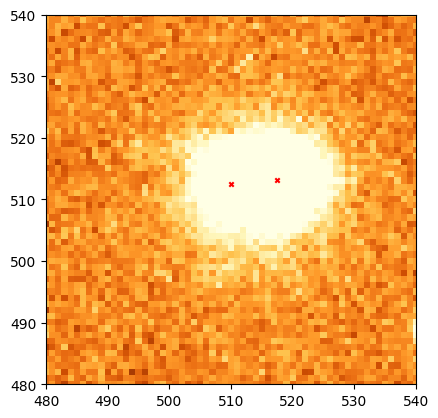

In [7]:
_ = plt.imshow(ccd37_proc_data, origin='lower', norm=norm, cmap='YlOrBr_r')

# Plot the detected sources
_ = plt.scatter(sources['xcentroid'], sources['ycentroid'], s=10, c='red', marker='x')

# Zoom on a region of the image for better visibility

_= plt.xlim(480, 540)
_ = plt.ylim(480, 540)

Centroid: 515.72, 512.90


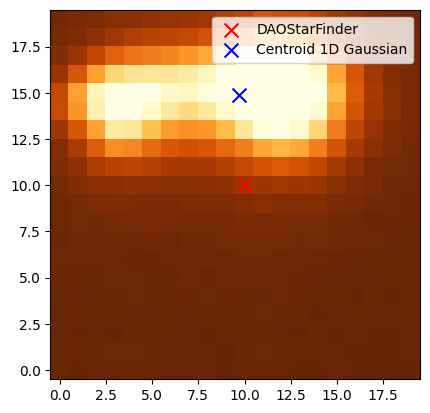

In [8]:
# Centroids of the source from DAOStarFinder
xd = 516
yd = 508

# Get a small region around the source

x0 = int(xd)
y0 = int(yd)
data = ccd37_proc_data[y0-10:y0+10, x0-10:x0+10]

# Calculate the centroid using the 1D Gaussian algorithm.
# It's important to remove the median background!
xc, yc = centroid_1dg(data - median)

# This centroid is with respect to the region we selected, so we need to add the offset
xc += (x0 - 10)
yc += (y0 - 10)

print(f'Centroid: {xc:.2f}, {yc:.2f}')

# Let's plot the two centroids estimates.
norm = ImageNormalize(data, interval=ZScaleInterval(), stretch=LinearStretch())
_ = plt.imshow(data, origin='lower', norm=norm, cmap='YlOrBr_r')
_ = plt.scatter(xd - x0 + 10, yd - y0 + 10, s=100, c='red', marker='x', label='DAOStarFinder')
_ = plt.scatter(xc - x0 + 10, yc - y0 + 10, s=100, c='blue', marker='x', label='Centroid 1D Gaussian')
_ = plt.legend()

In [9]:
aperture_sums=[]
times=[]

In [10]:
def do_aperture_photometry(
    image
):
    sci_data = fits.open(image)
    sci_proc_data = sci_data[0].data.astype('f4')

    times.append(sci_data[0].header['Date-OBS'])
    
    # Select a blank region of the image
    data_blank = sci_proc_data[100:200, 900:1000]
    
    # Calculate the mean, median and standard deviation of the blank region
    mean, median, std = sigma_clipped_stats(data_blank, sigma=3.0)
    #print(f'Mean: {mean:.2f}, Median: {median:.2f}, Std: {std:.2f}')

    # Run DAOStarFinder
    daofind = DAOStarFinder(fwhm=5.0, threshold=5*std)
    sources = daofind(sci_proc_data - median)

    # Centroids of the source from DAOStarFinder
    xd = 516
    yd = 508
    
    # Get a small region around the source
    x0 = int(xd)
    y0 = int(yd)
    data = sci_proc_data[y0-25:y0+25, x0-25:x0+25]
    
    # Calculate the centroid using the 1D Gaussian algorithm.
    # It's important to remove the median background!
    xc, yc = centroid_1dg(data - median)
    
    # This centroid is with respect to the region we selected, so we need to add the offset
    xc += (x0 - 25)
    yc += (y0 - 25)

    # Let's plot the two centroids estimates.
    '''
    norm = ImageNormalize(data, interval=ZScaleInterval(), stretch=LinearStretch())
    _ = plt.imshow(data, origin='lower', norm=norm, cmap='YlOrBr_r')
    _ = plt.scatter(xd - x0 + 25, yd - y0 + 25, s=100, c='red', marker='x', label='DAOStarFinder')
    _ = plt.scatter(xc - x0 + 25, yc - y0 + 25, s=100, c='blue', marker='x', label='Centroid 1D Gaussian')
    _ = plt.legend()
    _ = plt.show()
    '''
    
    # Define the annulus
    annulus = CircularAnnulus((xc, yc), r_in=10, r_out=15)

    annulus_stats = ApertureStats(sci_proc_data, annulus)
    back = annulus_stats.median
    std = annulus_stats.std

    aperture = CircularAperture((xc, yc), r=10)
    
    phot_table = aperture_photometry(sci_proc_data, aperture)
    flux = phot_table['aperture_sum'][0]
    aperture_area = aperture.area_overlap(sci_proc_data)
    flux_no_back = flux - back * aperture_area

    # Perform aperture photometry
    #phot_table = aperture_photometry(ccd37_proc_data - median, aperture)
    #print(phot_table)

    return aperture_sums.append(flux_no_back)

In [11]:
#do_aperture_photometry(f'~/work/ccd-reductions-mbosch2/Processed_2/KIC 9832227_r_20250606_040813.fits')
#aperture_sums

In [12]:
    import os
    directory_path = os.path.expanduser('Processed_2')
    file_list=[]
    for file_name in os.listdir(directory_path):
    #Check if it is a file
        if os.path.isfile(os.path.join(directory_path, file_name)):
            file_list.append(file_name)

    science_list=[]
    for i in file_list:
        science_list.append(directory_path+'/'+i)

In [13]:
for i in science_list:
    do_aperture_photometry(i)

In [14]:
import matplotlib.pyplot as plt
from datetime import datetime

In [15]:
x_vals = [datetime.fromisoformat(ts) for ts in times]
time_labels = [ts.strftime('%H:%M:%S') for ts in x_vals]

In [16]:
#log_ap = numpy.log10(aperture_sums)
y_vals = aperture_sums/numpy.max(aperture_sums)

In [17]:
combined = list(zip(time_labels, y_vals))
combined.sort(key=lambda x: x[0])

# Unzip the sorted pairs back into two lists
time_labels, y_vals = zip(*combined)

# Convert back to lists if needed
time_labels = list(time_labels)
y_vals = list(y_vals)


In [25]:
time_labels[y_vals.index(min(y_vals))]
1-min(y_vals)

np.float64(0.19219264554915316)

In [23]:
time_labels[-1]

'08:22:42'

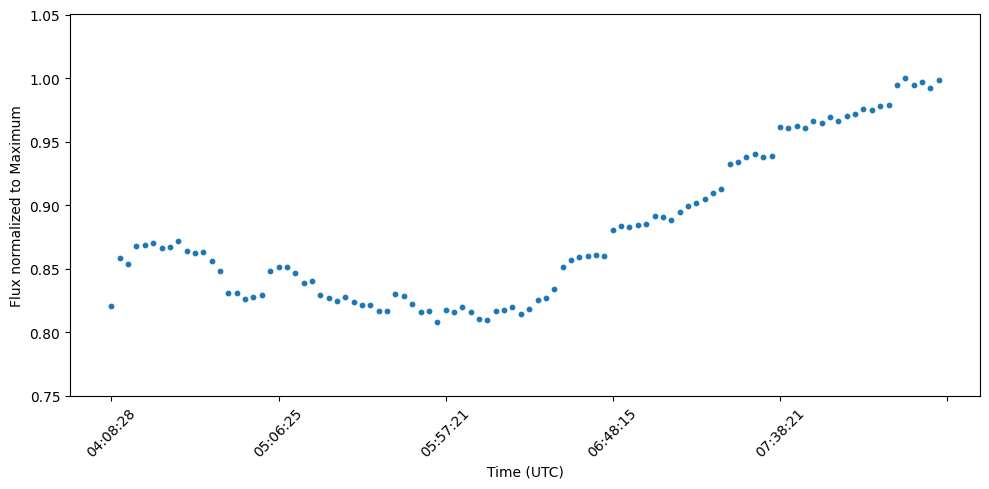

In [18]:
# Create the plot
plt.figure(figsize=(10, 5))
plt.scatter(time_labels, y_vals, s=10, marker='o')
plt.ylim(0.75, 1.05)
plt.xlabel('Time (UTC)')
plt.ylabel('Flux normalized to Maximum')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(6))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Light_curve_2')
